# NYPD Civilian Complaints Dataset

# Summary of Findings

### Introduction
In this notebook, I will be exploring the New York Police complaints data set, obtained from the [propublica data store](https://www.propublica.org/datastore/dataset/civilian-complaints-against-new-york-city-police-officers). I would like to investigate whether a difference in gender between police officer and complaintant is to be more severe than if the officer is the same gender as the complaintant. 

### Cleaning and EDA
We convert the complain start and end times to datetime, drop unnecessary/personal information, and clean entries for nulls. We also will visualize the gender distribution and distribution of severity in the dataset, and the test statistic visualized under the null hypothesis.

### Assessment of Missingness
We assess the missingness of columns with missing values

### Hypothesis Test
We perform a permutation test using mean as a test statistic and find out that there is a correlation between the gender difference and the severeness of the punishment given by the board.

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.stats import ks_2samp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Cleaning and EDA

## Loading and Data Overview
Firstly, we should load in the data into pandas.

In [2]:
complaints = pd.read_csv(os.path.join('data', 'allegations.csv'))
complaints

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33353,9992,Tomasz,Pulawski,078 PCT,2642,35671,8,2016,2,2017,...,36,Asian,Male,21.0,Discourtesy,Word,66.0,Moving violation,Moving violation summons issued,Unsubstantiated
33354,9992,Tomasz,Pulawski,078 PCT,2642,35671,8,2016,2,2017,...,36,Asian,Male,21.0,Abuse of Authority,Interference with recording,66.0,Moving violation,Moving violation summons issued,Unsubstantiated
33355,9992,Tomasz,Pulawski,078 PCT,2642,35671,8,2016,2,2017,...,36,Asian,Male,21.0,Abuse of Authority,Search (of person),66.0,Moving violation,Moving violation summons issued,Substantiated (Formalized Training)
33356,9992,Tomasz,Pulawski,078 PCT,2642,35671,8,2016,2,2017,...,36,Asian,Male,21.0,Abuse of Authority,Vehicle search,66.0,Moving violation,Moving violation summons issued,Substantiated (Formalized Training)


In [3]:
complaints['mos_age_incident']

0        32
1        24
2        24
3        25
4        39
         ..
33353    36
33354    36
33355    36
33356    36
33357    36
Name: mos_age_incident, Length: 33358, dtype: int64

<AxesSubplot:ylabel='Frequency'>

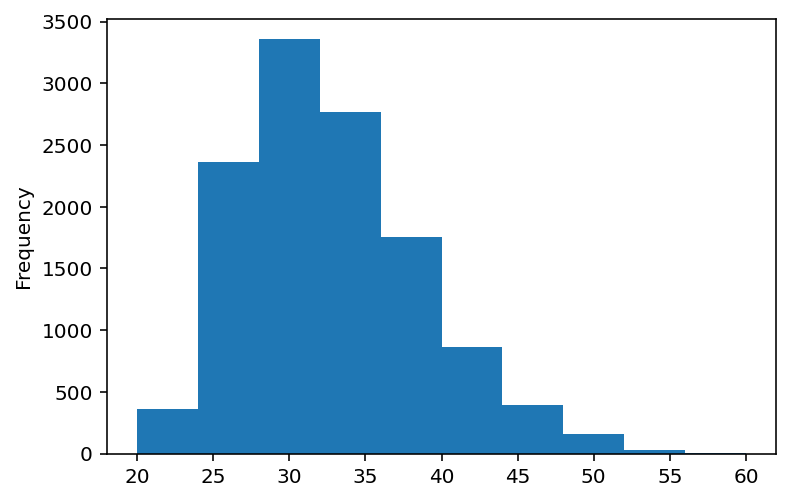

In [4]:
complaints.groupby('complaint_id')['mos_age_incident'].mean().plot(kind='hist')

### common acronyms
- PCT - Precinct
- PBBS - Patrol Borough Brooklyn South - Refers to a patrol unit in the South.

https://en.wikipedia.org/wiki/Civilian_Complaint_Review_Board

In [5]:
complaints['command_at_incident']

0        078 PCT
1           PBBS
2           PBBS
3           PBBS
4        078 PCT
          ...   
33353    066 PCT
33354    066 PCT
33355    066 PCT
33356    066 PCT
33357    066 PCT
Name: command_at_incident, Length: 33358, dtype: object

Not all of these columns are clear as to what they mean, but we can infer from the other columns in the row about what they may mean.

### Data Columns

Most of these column names are self-explanatory, but some are not and required research to understand.
Note that mos is a common abbreviation for Member of Service.
This is a list of some columns that may need clarification:
 - ```unique_mos_id``` - Unique member of service (**MoS**) id given to an officer by the CCRB, and not by the New York Police.
 - ```command_now``` - current commanding position of the officer.
 - ```shield_no``` - Badge/shield number of officer may possibly 
 - ```complaint_id``` - Unique id of given complaint. Complaints can have multiple different allegations as well.
 - ```command_at_incident``` - Commanding position of the officer at incident.
 - ```rank_abbrev_incident``` - rank of officer at the time the incident had occurred. 
 - ```fado_type``` - Categorization of police abuse as one of the following: [Force, Abuse of Authority, Discourtesy, and Offensive Language](https://www1.nyc.gov/site/ccrb/policy/data-transparency-initiative-allegations.page)
 - ```allegation``` - Alleged action of the officer that led to the filing of the complaint.
 - ```precinct``` - Precinct in which the complaint occurred
 - ```contact_reason``` - reason for why contact was made.
 - ```outcome_description``` - Outcome of given contact.
 - ```board_disposition``` - action taken by the board.

Many columns can be explained by the [various links given by the NYPD](https://www.nyclu.org/en/campaigns/nypd-misconduct-database).

## Data Cleaning

We should check to ensure that all data is in a reasonable data type.

In [6]:
complaints.dtypes

unique_mos_id                 int64
first_name                   object
last_name                    object
command_now                  object
shield_no                     int64
complaint_id                  int64
month_received                int64
year_received                 int64
month_closed                  int64
year_closed                   int64
command_at_incident          object
rank_abbrev_incident         object
rank_abbrev_now              object
rank_now                     object
rank_incident                object
mos_ethnicity                object
mos_gender                   object
mos_age_incident              int64
complainant_ethnicity        object
complainant_gender           object
complainant_age_incident    float64
fado_type                    object
allegation                   object
precinct                    float64
contact_reason               object
outcome_description          object
board_disposition            object
dtype: object

Most of the datatypes are of an appropriate type, as most can only be represented as a string, integer (if all non-null) and float (if has null values).

For the most part, the data is okay in terms of data type, except for precinct, which is more nominal than ordinal. We would also like to represent the month and year of the complain in terms of date time in order to analyze complaints over time. We are not given the exact date of the complaint, so we assign the complaint to be filed on the first day of a given month. There is also no missingness in any of these columns as well.

In [7]:
complaints['precinct'] = complaints['precinct'].astype(str)

In [8]:
date_conversion = lambda year, month: pd.to_datetime(year.astype(str) + '-' + month.astype(str).str.zfill(2))

In [9]:
complaints['received'] = date_conversion(complaints['year_received'], complaints['month_received'])
complaints['closed'] = date_conversion(complaints['year_closed'], complaints['month_closed'])
complaints = complaints.drop(columns=['month_received', 'year_received', 'month_closed', 'year_closed'])

We should also anonymize the data by dropping the officer name, as it does not contribute towards understanding the data better, and we have other more useful features about the officer, including ethnicity, gender, and age.

In [10]:
complaints = complaints.drop(columns=['first_name', 'last_name'])

## Null values

In [11]:
num_cols = complaints.columns[(complaints.dtypes == np.int64) | (complaints.dtypes == np.float64)]
for col in num_cols:
    print(complaints[col].value_counts(dropna=False).sort_index().head(5))

2     10
5      3
11     5
21     8
23    14
Name: unique_mos_id, dtype: int64
0     5392
2        1
5       20
10      14
12       2
Name: shield_no, dtype: int64
517    3
525    2
528    1
542    1
558    2
Name: complaint_id, dtype: int64
20       1
21      24
22     292
23     622
24    1266
Name: mos_age_incident, dtype: int64
-4301.0    1
-1.0       5
 0.0       2
 1.0       1
 2.0       2
Name: complainant_age_incident, dtype: int64


In [12]:
complaints.columns.difference(num_cols)

Index(['allegation', 'board_disposition', 'closed', 'command_at_incident',
       'command_now', 'complainant_ethnicity', 'complainant_gender',
       'contact_reason', 'fado_type', 'mos_ethnicity', 'mos_gender',
       'outcome_description', 'precinct', 'rank_abbrev_incident',
       'rank_abbrev_now', 'rank_incident', 'rank_now', 'received'],
      dtype='object')

In [13]:
object_cols = complaints.columns.difference(num_cols)
for col in object_cols:
    print(complaints[col].value_counts(dropna=False).head(5))

Physical force        4849
Word                  3942
Stop                  2300
Search (of person)    2047
Frisk                 1926
Name: allegation, dtype: int64
Unsubstantiated                         15448
Exonerated                               9609
Substantiated (Charges)                  3796
Substantiated (Formalized Training)      1033
Substantiated (Command Discipline A)      964
Name: board_disposition, dtype: int64
2015-09-01    414
2015-03-01    388
2017-02-01    384
2016-02-01    354
2014-12-01    335
Name: closed, dtype: int64
NaN        1544
075 PCT    1364
046 PCT     825
044 PCT     763
NARCBBN     746
Name: command_at_incident, dtype: int64
INT CIS    1412
WARRSEC    1165
NARCBBX     692
DB CEIS     683
075 PCT     415
Name: command_now, dtype: int64
Black       17114
Hispanic     6424
NaN          4464
White        2783
Unknown      1041
Name: complainant_ethnicity, dtype: int64
Male                24058
Female               5021
NaN                  4195
Not des

From some of the columns, we see some candidates for data that should be marked as missing:
- shield_no of 0
- Precincts with values of 0 or 1000
- Gender - Not described
- complaintant_age_incident contains unreasonable values (negative, under 5, etc.)
- complaintant_ethnicity - Unknown and refused


In [14]:
# Clean shield numbers for zero values
complaints['shield_no'] = complaints['shield_no'].replace(0, np.NaN)

In [15]:
complaints['precinct'].value_counts(dropna=False).index

Index(['75.0', '73.0', '44.0', '46.0', '67.0', '79.0', '40.0', '77.0', '47.0',
       '120.0', '81.0', '43.0', '52.0', '70.0', '113.0', '32.0', '48.0',
       '42.0', '83.0', '71.0', '25.0', '23.0', '101.0', '103.0', '41.0',
       '69.0', '60.0', '105.0', '90.0', '34.0', '114.0', '121.0', '14.0',
       '28.0', '30.0', '49.0', '63.0', '33.0', '18.0', '110.0', '9.0', '72.0',
       '115.0', '10.0', '102.0', '122.0', '84.0', '88.0', '68.0', '45.0',
       '7.0', '104.0', '50.0', '61.0', '106.0', '24.0', '109.0', '62.0', '6.0',
       '1.0', '107.0', '19.0', '5.0', '76.0', '26.0', '13.0', '108.0', '100.0',
       '112.0', '78.0', '94.0', '123.0', '20.0', '66.0', '17.0', '111.0',
       'nan', '0.0', '22.0', '1000.0'],
      dtype='object')

To clean up the precinct column, I used the [NYPD precincts page](https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page) to get a general idea of the range of precincts in New York. The main two precincts that do not exist are the 0th and 1000th precincts.

In [16]:
complaints['precinct'] = complaints['precinct'].replace({0.0: np.NaN, 1000.0: np.NaN})

In [17]:
complaints['complainant_gender'] = complaints['complainant_gender'].replace({'Not described': np.NaN})
complaints['complainant_ethnicity'] = complaints['complainant_ethnicity'].replace({'Unknown': np.NaN})

In [18]:
complaints['complainant_age_incident'].value_counts().sort_index().head(15)

-4301.0      1
-1.0         5
 0.0         2
 1.0         1
 2.0         2
 3.0         1
 6.0         1
 7.0         1
 8.0         3
 9.0         4
 10.0       10
 11.0       23
 12.0       63
 13.0      121
 14.0      254
Name: complainant_age_incident, dtype: int64

For determining invalid/missing values, we will assume that complaints made under the age of 13 are inaccurate, because it would be highly unlikely for people under these ages to have filed a police report. From these errors, they may suggest that these ages were hand-entered.

In [19]:
complaints['complainant_age_incident'] = complaints['complainant_age_incident'].apply(lambda x: x if x >= 13 else np.NaN)

In [20]:
complaints['complainant_age_incident'].value_counts().sort_index().head(10)

13.0    121
14.0    254
15.0    402
16.0    475
17.0    631
18.0    687
19.0    888
20.0    843
21.0    955
22.0    931
Name: complainant_age_incident, dtype: int64

In [21]:
complaints['board_disposition'].value_counts()

Unsubstantiated                             15448
Exonerated                                   9609
Substantiated (Charges)                      3796
Substantiated (Formalized Training)          1033
Substantiated (Command Discipline A)          964
Substantiated (Command Discipline)            851
Substantiated (Command Discipline B)          789
Substantiated (Command Lvl Instructions)      454
Substantiated (Instructions)                  248
Substantiated (No Recommendations)            165
Substantiated (MOS Unidentified)                1
Name: board_disposition, dtype: int64

In quantifying the severeness of the punishment, we give a simple number rating rated by the [CCRB](https://www1.nyc.gov/site/ccrb/prosecution/police-discipline.page):
- Unsubstantiated gives a severeness of 0, as no further action was taken against the officer.
- Instructions and Formalized Training give a severeness of 3.
- Command Discipline gives a severeness of 6, as the CCRB describes this penalty as more problematic than just "poor training."
- Charges gives a severeness of 8
- Exonerated gives a severeness of 10.
Other substantiated dispositions are worth 2, as they are not as severe.

In [22]:
subst_charges = {
    'Charges':8,
     'Formalized Training':3,
     'Command Discipline A':6,
     'Command Discipline':6,
     'Command Discipline B':6,
     'Command Lvl Instructions':6,
     'Instructions':3,
     'No Recommendations':2,
     'MOS Unidentified':2
}


In [23]:
def severeness(disposition):
    if disposition == 'Unsubstantiated':
        return 0
    elif disposition == 'Exonerated':
        return 10
    
    # Get the cause 
    substantiated_case = disposition[disposition.find('(') + 1: disposition.find(')')]
    return subst_charges[substantiated_case]

In [24]:
complaints['severeness'] = complaints['board_disposition'].apply(severeness)
complaints['severeness'].value_counts()

0     15448
10     9609
8      3796
6      3058
3      1281
2       166
Name: severeness, dtype: int64

Secondly, we wish to determine whether the officer's gender is the same as the 

In [25]:
complaints['complainant_gender'].value_counts(dropna=False)

Male                     24058
Female                    5021
NaN                       4252
Transwoman (MTF)            20
Transman (FTM)               5
Gender non-conforming        2
Name: complainant_gender, dtype: int64

In [26]:
complaints['mos_gender'].value_counts(dropna=False)

M    31598
F     1760
Name: mos_gender, dtype: int64

We must ethically consider the values of transgender and non male/female complainants. In this case, we will assume that a person belonging to LGBTQ+ assumes the role that they have personally declared, and not biological gender. We will also  keep the two nonbinary as neither male nor female. Since we are cleaning the complainant gender, we will also make it match the officer gender format.

In [27]:
conversions = {
    'Male': 'M',
    'Female': 'F',
    'Transwoman (MTF)':'F',
    'Transman (FTM)': 'M',
    'Gender non-conforming': 'NB'
}

In [28]:
complaints['complainant_gender'] = complaints['complainant_gender'].replace(conversions)
complaints['complainant_gender'].value_counts(dropna=False)

M      24063
F       5041
NaN     4252
NB         2
Name: complainant_gender, dtype: int64

We can now determine whether the officer gender matches the complainant gender.

In [29]:
complaints['same_gender'] = (complaints['complainant_gender'] == complaints['mos_gender'])
complaints['same_gender'].value_counts()

True     23707
False     9651
Name: same_gender, dtype: int64

### Imputation of Null values

We are given some information on how this data was generated; the generated data comes from a [website form](https://www1.nyc.gov/site/ccrb/complaints/file-online.page) from the CCRB, in which some of the columns in the dataset correspond to optional forms at times. Many of the given missing columns correspond to the fact that the form does not require these fields. You can also file a complaint for another victim as well.

In [30]:
complaints.isnull().sum()

unique_mos_id                  0
command_now                    0
shield_no                   5392
complaint_id                   0
command_at_incident         1544
rank_abbrev_incident           0
rank_abbrev_now                0
rank_now                       0
rank_incident                  0
mos_ethnicity                  0
mos_gender                     0
mos_age_incident               0
complainant_ethnicity       5505
complainant_gender          4252
complainant_age_incident    4929
fado_type                      0
allegation                     1
precinct                       0
contact_reason               199
outcome_description           56
board_disposition              0
received                       0
closed                         0
severeness                     0
same_gender                    0
dtype: int64

Shield number cannot be imputated because shield number usually belongs to a given officer, and we cannot recover these numbers through imputation. We could search an officer's unique mos id to find other possible shield numbers tied to the id, but there are many cases in which the officer does not have other shield numbers as well.

In [31]:
complaints['command_at_incident'].value_counts()

075 PCT    1364
046 PCT     825
044 PCT     763
NARCBBN     746
079 PCT     737
           ... 
CA SECT       1
A P DIV       1
POL ACD       1
COMMSEC       1
032 DET       1
Name: command_at_incident, Length: 361, dtype: int64

One thing we must determine is the assessment of missingness in the mos_gender column, as this column contributes greatly to the overall data, especially when the column's null values are almost as much as female complainants.

<AxesSubplot:title={'center':'Complainant Gender Count'}, xlabel='complainant_gender'>

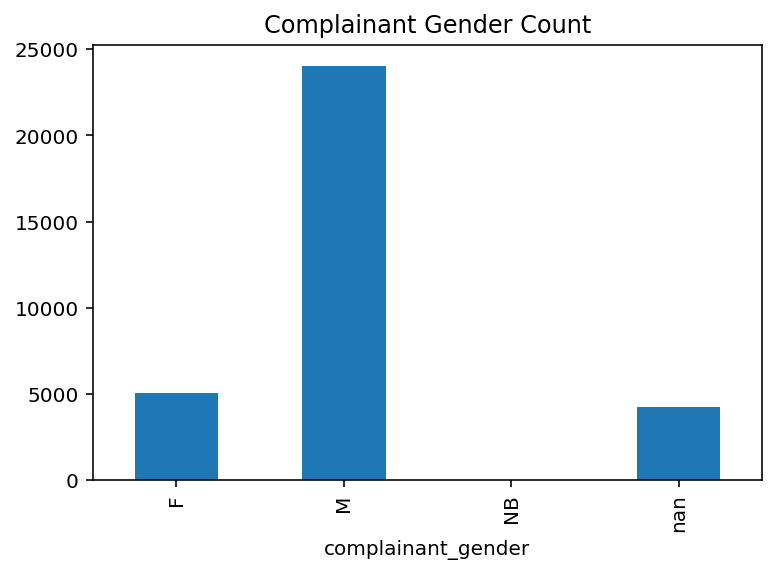

In [32]:
complaints.groupby('complainant_gender', dropna=False).size().plot(kind='bar', title='Complainant Gender Count')

In [33]:
nulls = complaints['complainant_gender'].isnull()

In [34]:
complainant_cols = complaints.columns[complaints.columns.str.contains('complainant')]
complainant_cols

Index(['complainant_ethnicity', 'complainant_gender',
       'complainant_age_incident'],
      dtype='object')

In [35]:
complaints[nulls][complainant_cols].isnull().sum()

complainant_ethnicity       4212
complainant_gender          4252
complainant_age_incident    4159
dtype: int64

### Exploratory Data Analysis

Firstly, I want to search for variables that involve the severity of officers or the gender of complainants and police officers. Keep in note that a considerable amount of genders are null, which currently skew the amount of gender mismatches. For this, we will trim the dataframe for uninvolved columns, and nulls will also be considered, as they contribute significantly to the non-same gender group.

In [36]:
gender = complaints[['unique_mos_id', 'shield_no', 'fado_type', 'board_disposition', 'mos_gender','complainant_gender','severeness', 'same_gender']]
gender

,unique_mos_id,shield_no,fado_type,board_disposition,mos_gender,complainant_gender,severeness,same_gender
0,10004,8409.0,Abuse of Authority,Substantiated (Command Lvl Instructions),M,F,6,False
1,10007,5952.0,Discourtesy,Substantiated (Charges),M,M,8,True
2,10007,5952.0,Offensive Language,Substantiated (Charges),M,M,8,True
3,10007,5952.0,Abuse of Authority,Substantiated (Charges),M,M,8,True
4,10009,24058.0,Force,Substantiated (Command Discipline A),F,NaN,6,False
...,...,...,...,...,...,...,...,...
33353,9992,2642.0,Discourtesy,Unsubstantiated,M,M,0,True
33354,9992,2642.0,Abuse of Authority,Unsubstantiated,M,M,0,True
33355,9992,2642.0,Abuse of Authority,Substantiated (Formalized Training),M,M,3,True
33356,9992,2642.0,Abuse of Authority,Substantiated (Formalized Training),M,M,3,True


In [37]:
gender_no_null = gender[gender['complainant_gender'].isnull() != True]
gender_no_null.shape[0]

29106

<AxesSubplot:title={'center':'Complainant gender distribution'}, xlabel='complainant_gender'>

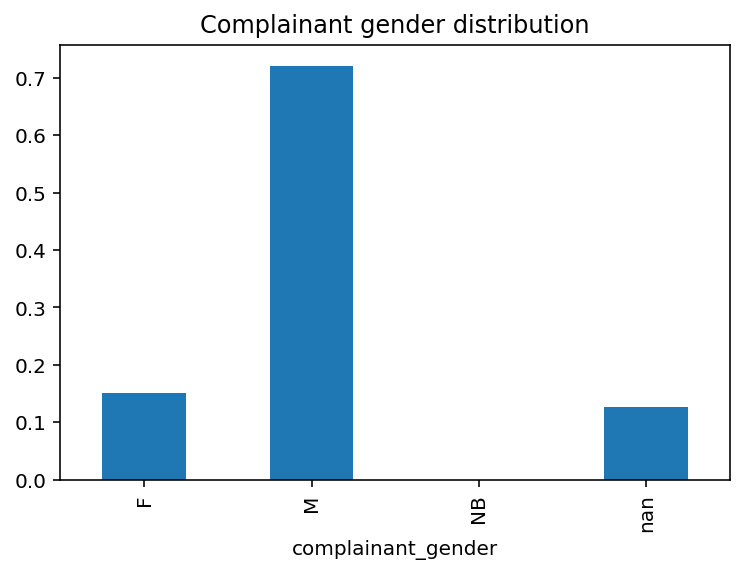

In [38]:
(gender.groupby('complainant_gender', dropna=False).size() / gender.shape[0]).plot(kind='bar', title='Complainant gender distribution')

<AxesSubplot:title={'center':'Severeness of punishment by same gender (counting nulls as false)'}, ylabel='Same Gender'>

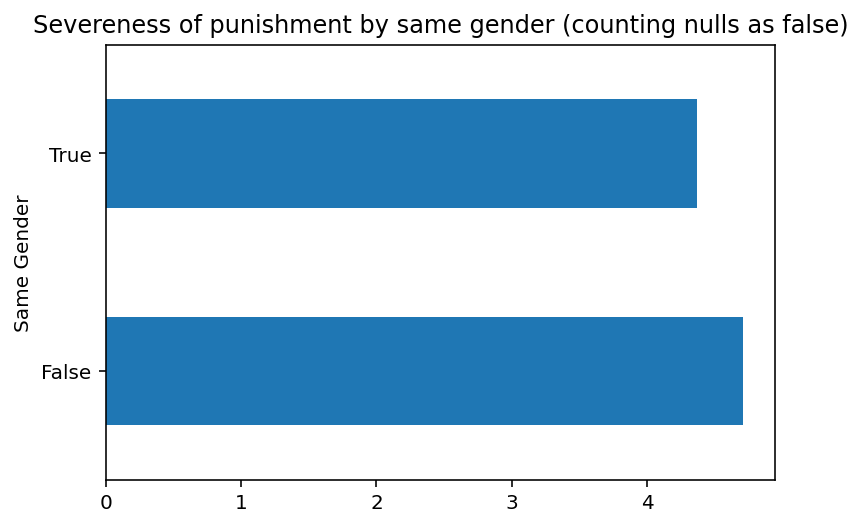

In [39]:
gender.groupby('same_gender').mean()['severeness'].plot(kind='barh', title='Severeness of punishment by same gender (counting nulls as false)', xlabel='Same Gender')

<AxesSubplot:title={'center':'Average severeness of punishment by same gender (counting nulls as false)'}, ylabel='Same Gender'>

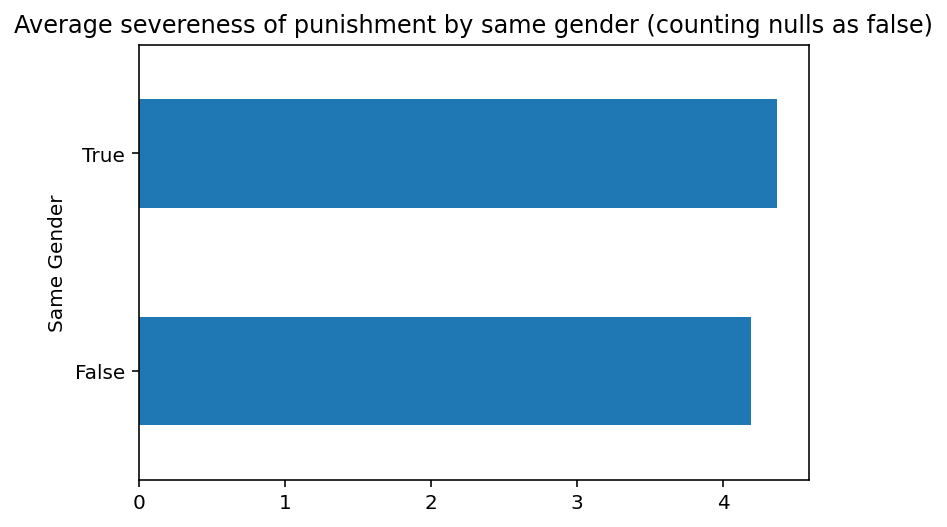

In [40]:
gender_no_null.groupby('same_gender').mean()['severeness'].plot(kind='barh', title='Average severeness of punishment by same gender (counting nulls as false)', xlabel='Same Gender')

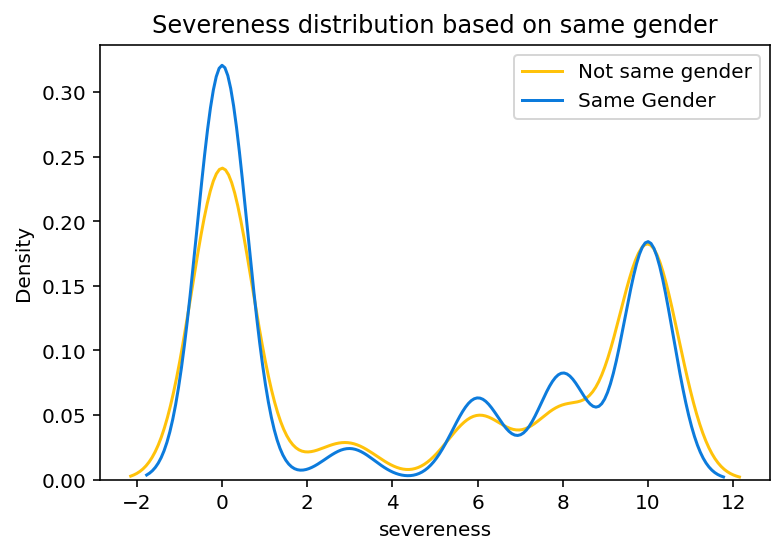

In [41]:
sns.kdeplot(data=gender[gender['same_gender'] != True], x='severeness', color='#FFC20A', label='Not same gender')
sns.kdeplot(data=gender[gender['same_gender']], x='severeness', color='#0C7BDC', label='Same Gender')
plt.title('Severeness distribution based on same gender')
plt.legend()

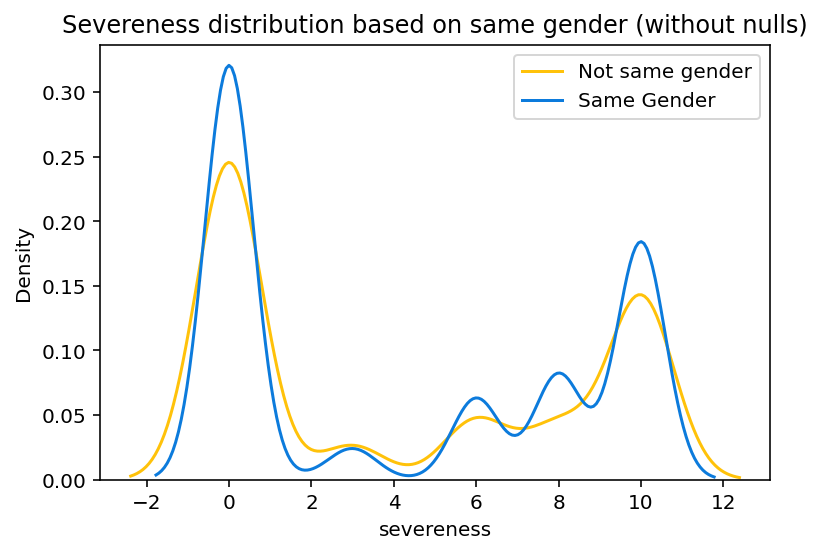

In [42]:
sns.kdeplot(data=gender_no_null[gender_no_null['same_gender'] != True], x='severeness', color='#FFC20A', label='Not same gender')
sns.kdeplot(data=gender_no_null[gender_no_null['same_gender']], x='severeness', color='#0C7BDC', label='Same Gender')
plt.title('Severeness distribution based on same gender (without nulls)')
plt.legend()

One thing that is noticed is the presence of more unsubstantiated/0-level severeness claims when the gender is the same, which could hint that the board disposition is more severe when the gender does not match. It is also interesting that the null values contribute greatly to the difference in data as well, so we should first clean this column further.

We would also like to understand the distribution of severeness as well.

<AxesSubplot:xlabel='severeness', ylabel='Count'>

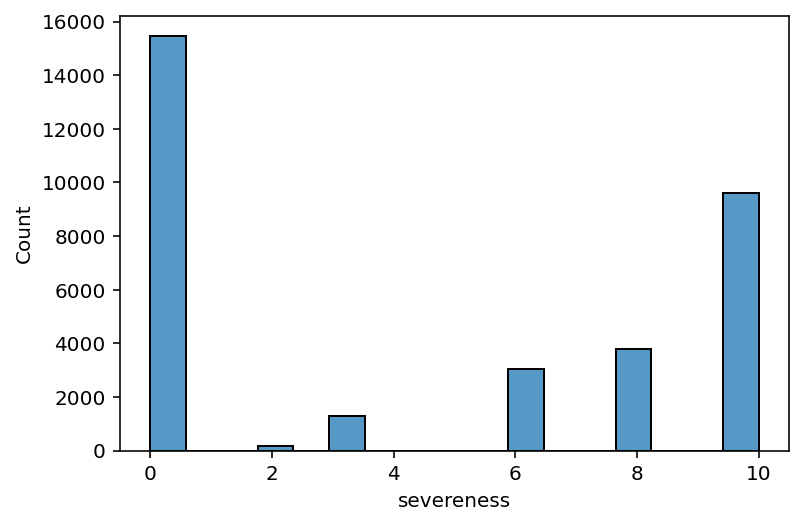

In [43]:
sns.histplot(data=gender, x='severeness')

## Assessment of Missingness

In [44]:
complaints.isnull().sum()

unique_mos_id                  0
command_now                    0
shield_no                   5392
complaint_id                   0
command_at_incident         1544
rank_abbrev_incident           0
rank_abbrev_now                0
rank_now                       0
rank_incident                  0
mos_ethnicity                  0
mos_gender                     0
mos_age_incident               0
complainant_ethnicity       5505
complainant_gender          4252
complainant_age_incident    4929
fado_type                      0
allegation                     1
precinct                       0
contact_reason               199
outcome_description           56
board_disposition              0
received                       0
closed                         0
severeness                     0
same_gender                    0
dtype: int64

There are a few number of columns that are missing. We will cover them in order as seen above. If a value is suspected to be MCAR or NI, it will be stated here:
- ```shield_no``` is missing completely at random because the missingness of the shield number is not dependent on other columns nor the true value of the column. This is the same reason that imputation cannot happen.
- ```command_at_incident ```
- ```complainant_ethnicity```
- ```complainant_age_incident```
- ```allegation``` is most likely missing completely at random, as we cannot be sure if the data is reliant on other columns through only one observation. It could also possibly be missing at random due to the fact that the case was unsubstantiated, possibly due to the lack of information.
- ```contact_reason``` -
- ```outcome_description```

In [45]:
complaints[complaints['allegation'].isnull()]

,unique_mos_id,command_now,shield_no,complaint_id,command_at_incident,rank_abbrev_incident,rank_abbrev_now,rank_now,rank_incident,mos_ethnicity,...,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition,received,closed,severeness,same_gender
3982,15188,120 PCT,1517.0,860,NaN,PO,SGT,Sergeant,Police Officer,White,...,Force,NaN,70.0,Patrol Encounter,No arrest made or summons issued,Unsubstantiated,1989-05-01,1989-05-01,0,False


Reasonable columns that can be used to test for MAR are the following, as the others do not have a great relation or are too specific:
- rank_abbrev_incident and rank_abbrev_now
- fado_type
- mos age, ethnicity, and gender
- allegations
- board disposition (severeness is possibly better)


### Missingness classification

We will identify the type of missingness for the unclear missing columns. 

In [46]:
categoricals = 'rank_abbrev_incident', 'rank_abbrev_now', 'fado_type', 'mos_ethnicity', 'mos_gender', 'allegation', 'allegation'
ordinals = 'mos_age_incident', 'severeness'

In [47]:
def tvd(dist1, dist2):
    return (dist1 - dist2).abs().sum() / 2

In [48]:
def null_permutation_test(dataset, missing_col, suspected_col, repetitions=100):
    """ Returns the p value of the likely hood that the two distributions are generated the same way, with the suspected column being quantitative."""
    repetitions = 1000
    tvds = np.zeros(repetitions)
    
    is_null = dataset[missing_col].isnull()
    obs_dist_null = dataset[is_null][suspected_col].value_counts(normalize=True)
    obs_dist_non_null = dataset[~is_null][suspected_col].value_counts(normalize=True)
    observed = tvd(obs_dist_null, obs_dist_non_null)
    
    # Get test stat from permuted nulls
    for i in range(repetitions):
        # Shuffle null column
        is_null = np.random.permutation(is_null)
        null_dist = dataset[suspected_col][is_null].value_counts(normalize=True)
        non_null_dist = dataset[suspected_col][~is_null].value_counts(normalize=True)
        tvds[i] = tvd(null_dist, non_null_dist)
        
    return np.mean(tvds >= observed)

In [49]:
def null_ks_2samp(data, missing_col, suspected_col):
    """ Calculate p value of numerical columns compared with the null values of missing column"""
    nulls = data[missing_col].isnull()
    return ks_2samp(data[suspected_col][nulls], data[suspected_col][~nulls]).pvalue

In [50]:
def get_relations(data, missing_col):
    """ Get the simulated probabilities that missingness of the missing column is dependent on other columns."""
    p_values = {}
    for nominal in categoricals:
        p_values[nominal] = null_permutation_test(data, missing_col, nominal)
    
    for ordinal in ordinals:
        p_values[ordinal] = null_ks_2samp(data, missing_col, ordinal)
        
    return p_values

In [51]:
get_relations(complaints, 'command_at_incident')

{'rank_abbrev_incident': 0.0,
 'rank_abbrev_now': 0.0,
 'fado_type': 0.0,
 'mos_ethnicity': 0.0,
 'mos_gender': 0.0,
 'allegation': 0.0,
 'mos_age_incident': 9.024556035686833e-208,
 'severeness': 1.6579991421420407e-29}

In [52]:
get_relations(complaints, 'complainant_ethnicity')

{'rank_abbrev_incident': 0.0,
 'rank_abbrev_now': 0.0,
 'fado_type': 0.0,
 'mos_ethnicity': 0.0,
 'mos_gender': 0.0,
 'allegation': 0.0,
 'mos_age_incident': 1.0395155513821507e-11,
 'severeness': 4.049622393956761e-41}

In [53]:
get_relations(complaints, 'complainant_age_incident')

{'rank_abbrev_incident': 0.0,
 'rank_abbrev_now': 0.0,
 'fado_type': 0.0,
 'mos_ethnicity': 0.0,
 'mos_gender': 0.0,
 'allegation': 0.0,
 'mos_age_incident': 7.96148098406147e-14,
 'severeness': 2.0817992505975204e-45}

In [54]:
get_relations(complaints, 'contact_reason')

{'rank_abbrev_incident': 0.319,
 'rank_abbrev_now': 0.0,
 'fado_type': 0.058,
 'mos_ethnicity': 0.095,
 'mos_gender': 0.76,
 'allegation': 0.0,
 'mos_age_incident': 1.2485026052229808e-05,
 'severeness': 0.9721413637391787}

In [55]:
get_relations(complaints, 'outcome_description')

{'rank_abbrev_incident': 0.062,
 'rank_abbrev_now': 0.0,
 'fado_type': 0.005,
 'mos_ethnicity': 0.037,
 'mos_gender': 0.067,
 'allegation': 0.002,
 'mos_age_incident': 0.011843266387977391,
 'severeness': 0.6141879369323828}

From these tests, we identify the following columns with given missingness:
- command_at_incident, complainant_ethnicity, complainant_age_incident, contact_reason, and outcome_description are all **MAR**.

### Hypothesis Test

We can choose to ignore or include the ethnicities of the complainant's gender. To do this, we can use the null_ks_2samp function to find the probability that the distributions are the same. We will cover imputated and non-imputated cases for this question.

- Null hypothesis: The difference of gender between officer and complainant have no significance on the severeness of the punishment given by the board.
- Alternative hypothesis: The difference of gender between officer and complainant bear significance on the severeness of the punishment given by the board.
- Test statistic: Mean
- P value cutoff: .05

In [56]:
not_same_gender = gender_no_null[gender_no_null['same_gender'] != True]
same_gender = gender_no_null[gender_no_null['same_gender']]

In [57]:
ks_2samp(not_same_gender['severeness'], same_gender['severeness'])

KstestResult(statistic=0.03112882717173515, pvalue=0.000388827479000242)

We might wish to also visualize the difference, so we can also use a permutation test to determine whether the distributions are different, with the test statistic being the mean of each group:

In [58]:
observed = same_gender['severeness'].mean() - not_same_gender['severeness'].mean()
observed

0.1781571982388277

In [59]:
iterations = 1000
means = np.zeros(iterations)

groups = gender_no_null['same_gender']
severeness_col = gender_no_null['severeness']
for i in range(iterations):
    # Shuffle the missing columns
    groups = np.random.permutation(groups)
    # Get distribution of both groups
    same_gen_dist = severeness_col[groups].mean()
    diff_gen_dist = severeness_col[~groups].mean()
    means[i] = same_gen_dist - diff_gen_dist

Text(0.5, 1.0, 'Permutation test results')

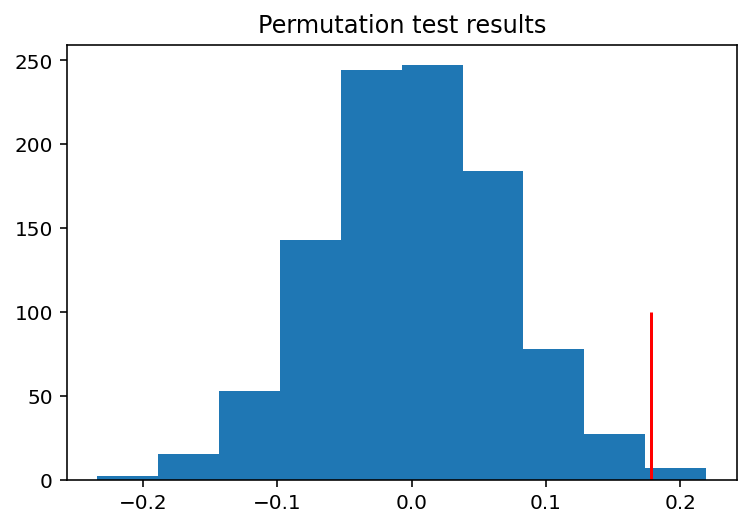

In [60]:
plt.hist(x=means)
plt.vlines(x=observed, ymin=0, ymax=100, color='red')
plt.title('Permutation test results')

Because the majority of the graph is to the left of observed, we should compute the probability that we see a value more than the observed value:

In [61]:
np.mean(means > observed)

0.006

We get a value that rejects the null hypothesis and are more inclined to accept the alternative hypothesis stating that **complaints among the same gender are on average are correlated with more severe punishments than complaints with the officer having a different gender than the complainant**.

Because we are using observed data, we cannot assume that the two variables have a causal relationship however.

## Conclusion

While we do see that there is a correlation between the gender difference and severeness, there are possible flaws in such an approach. The most obvious one is the weighting of the board decisions, as the changing of these weights could yield a different result. There is also some uncertainty with the data due to the missingness of some of the complainant genders as well.

This question could be further improved with a machine learning model that could help imputate the complainant gender column. Another way to improve this question's reliability would be to imputate using the demographics of New York as well.